# PS6 - Particle Tracking
## Simon Le Goff

In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import math
from math import *
import random 

import matplotlib.gridspec as gridspec

In [2]:
patch_pres_data=np.loadtxt('pres_debate.txt')
patch_pres_data_noise=np.loadtxt('noisy_debate.txt')

In [3]:
def measure(particle_patch ,tracked_patch, std_MSE=5):    
    cv2.normalize(particle_patch, particle_patch, alpha=0, beta=255,
                               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.normalize(tracked_patch, tracked_patch, alpha=0, beta=255,
                               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mse = np.sum(np.subtract(particle_patch, tracked_patch, dtype=np.float32) ** 2)
    mse /= float(particle_patch.shape[0] * particle_patch.shape[1])
    #print('mse',mse)
    #print('exp',np.exp(-mse / 2 / std_MSE**2))
    return np.exp(-mse / 2 / std_MSE**2)
    
def get_patch(part, frame, window_size):
    w,h=window_size
    w = int(w)
    h = int(h)
    #print(part)
    minu = (part[0]-w/2)
    maxu = (part[0]+w/2)
    minv = (part[1]-h/2)
    maxv = (part[1]+h/2)
    
    return frame[int(minv):int(maxv),int(minu):int(maxu)] 


# 1- Particle Filter Tracking

In this part we want to implement a naive particle filter tracking to track the Romney's face. In this implementation the patch we are tracking will always be the same, Romney's face from the first frame of the video. 

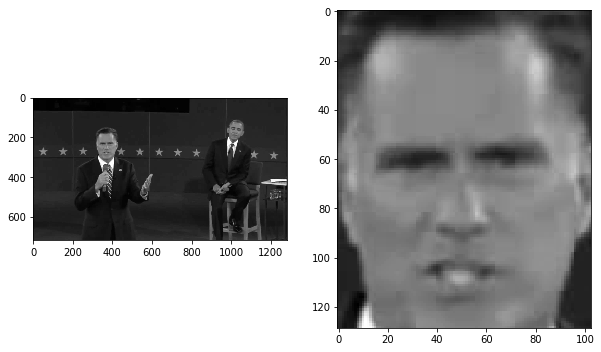

In [4]:
patch_pres_data=np.loadtxt('pres_debate.txt')
first_frame=cv2.imread('pres_first_frame.png',cv2.IMREAD_GRAYSCALE)

part_nb = 100

corn_u,corn_v,w,h=patch_pres_data
window_size=(w,h)
tracked_patch = get_patch([int(corn_u+w/2),int(corn_v+h/2)],first_frame,window_size)

initial_state=np.zeros((part_nb,2))
initial_state[:,0],initial_state[:,1]=(corn_u+w/2).astype(int),(corn_v+h/2).astype(int)


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(first_frame, cmap = 'gray')
plt.subplot(122)
plt.imshow(tracked_patch, cmap = 'gray')


In [5]:
class NaiveParticleFilter:
    def __init__(self, state, tracked_patch, window_size, part_nb, std_pred=10, std_up=5):
        self.std_pred = std_pred
        self.std_up = std_up
        self.tracked_patch = tracked_patch
        self.state = state
        self.weights = np.ones(np.shape(state)[0])/np.shape(state)[0]
        self.window_size = window_size
        self.part_nb = part_nb
        
    def predict(self):
        noise = np.random.randn(self.part_nb, 2) * self.std_pred
        #noise=np.random.normal(0.0, self.std_pred, (self.part_nb, 2))
        self.state+=noise

    def get_weights(self, frame):
        err_part = np.zeros(self.part_nb) 
        for ind, part in enumerate(self.state):     
            part_patch = get_patch(part, frame, self.window_size) 
            err_part[ind] = measure(part_patch,self.tracked_patch)
        self.weights = err_part/np.sum(err_part)

    def update(self, frame):
        self.get_weights(frame)
        indsampled = np.random.choice(self.part_nb, size=self.part_nb, replace=True, p=self.weights)
        up_state = self.state[indsampled]
        self.state = up_state #+ np.random.normal(0.0, self.std_up, (self.part_nb, 2))
        
    def draw_particles(self,frame):
        weights_for_color = ((self.weights - self.weights.min()) / self.weights.max() * 255).astype(int)
        for p, w in zip(self.state, weights_for_color.tolist()):
            cv2.circle(frame, (int(p[0]), int(p[1])), 2, (w,0,0), -1)            
            

    def draw_tracking_window(self,frame):
        w,h = self.window_size
        
        est_x = np.average(self.state[:,0], weights = self.weights)
        est_y = np.average(self.state[:,1], weights = self.weights)
        top_u_curr=int(est_x - w/2)
        top_v_curr=int(est_y - h/2)
        cv2.rectangle(frame,(top_u_curr,top_v_curr),(int(top_u_curr+w),int(top_v_curr+h)),(255, 0, 0), 3)
        
    def draw_std_circle(self,frame):
        est_x = np.average(self.state[:,0], weights = self.weights)
        est_y = np.average(self.state[:,1], weights = self.weights)
        
        average_state = np.zeros((self.part_nb,2))
        average_state[:,0] = est_x
        average_state[:,1] = est_y
        
        distance = np.linalg.norm(self.state - average_state)
        radius = np.sum(distance * self.weights)
        
        cv2.circle(frame,(int(est_x),int(est_y)),int(radius),(128,128,0), 2)

In the Class NaiveParticleFilter can be found multiple methods.<br>
predict() will just add a bit of Gaussian Noise to the position of each particle, because the face we are tracking is moving. <br>
In get_weights(), for each particle of the estimated state, the similarity is computed between the patch of which the particle is the center and the patch we are tracking. A high similarity will give a high weight for the particle. The weights are then normalized so that each weight corresponds to a probability. <br>
In update(), the particles of the state are resampled according to their weights to give the new state.

In [6]:
npf = NaiveParticleFilter(initial_state, tracked_patch, window_size, part_nb=100)

#video = cv2.VideoCapture('pres_debate.avi')   
video = cv2.VideoCapture('noisy_debate.avi')

frames_counter = 0

while video.isOpened():
    frames_counter = frames_counter + 1
    check, frame = video.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    npf.predict()
    npf.get_weights(gray)
    npf.update(gray)
    
    if not check:
        break
    
    npf.draw_particles(frame)
    npf.draw_tracking_window(frame)
    npf.draw_std_circle(frame)
    
    if frames_counter == 28:
        cv2.imwrite('output/NoisyDebate/pres_debate_frame_28_noisy.png', frame)
    
    if frames_counter == 84:
        cv2.imwrite('output/NoisyDebate/pres_debate_frame_84_noisy.png', frame)
    
    if frames_counter == 144:
        cv2.imwrite('output/NoisyDebate/pres_debate_frame_144_noisy.png', frame)
        
    
    cv2.imshow("Capturing", frame)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
    
print("Number of frames in the video: ", frames_counter)
video.release()
cv2.destroyAllWindows()

Number of frames in the video:  41


We saved the result for the frames 28, 84 and 144. <br>
On each frames are represented the state of each particles, the blue ones are the one with more weight (their patch is closer to the tracked patch), the box which center is the weighted average of all the particles and the circle to represent the spread of the distribution, the sum of the standard deviation of each particle.

(-0.5, 1279.5, 719.5, -0.5)

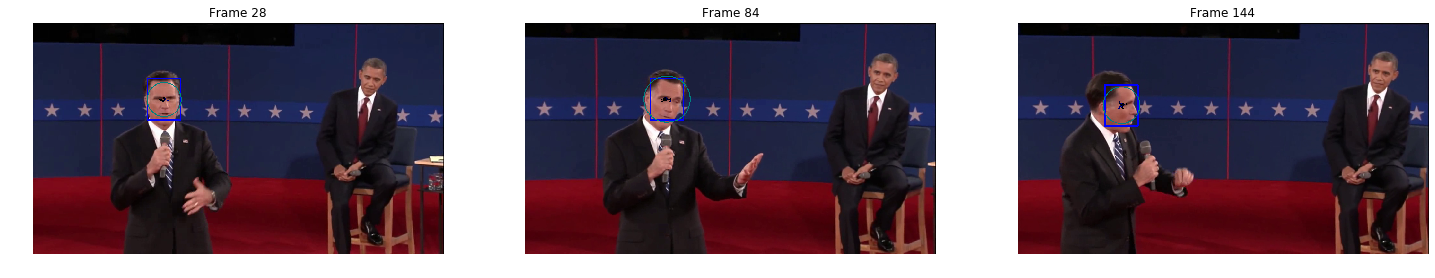

In [7]:
pres_debate_frame_28 = cv2.imread('output/pres_debate_frame_28.png',cv2.IMREAD_COLOR)
pres_debate_frame_84 = cv2.imread('output/pres_debate_frame_84.png',cv2.IMREAD_COLOR)
pres_debate_frame_144 = cv2.imread('output/pres_debate_frame_144.png',cv2.IMREAD_COLOR)

plt.figure(figsize=(25,25))
plt.subplot(131)
plt.imshow(cv2.cvtColor(pres_debate_frame_28, cv2.COLOR_BGR2RGB))
plt.title('Frame 28')
plt.axis("off")
plt.subplot(132)
plt.imshow(cv2.cvtColor(pres_debate_frame_84, cv2.COLOR_BGR2RGB))
plt.title('Frame 84')
plt.axis("off")
plt.subplot(133)
plt.imshow(cv2.cvtColor(pres_debate_frame_144, cv2.COLOR_BGR2RGB))
plt.title('Frame 144')
plt.axis("off")

### 1.2 - Influence of the dimension of the window image patch 

In the first part we applied our tracker on a window of 103x129 pixels. <br>
Let's see the results with different window sizes : 200x200, 60x60 and 30x30.  

(-0.5, 1279.5, 719.5, -0.5)

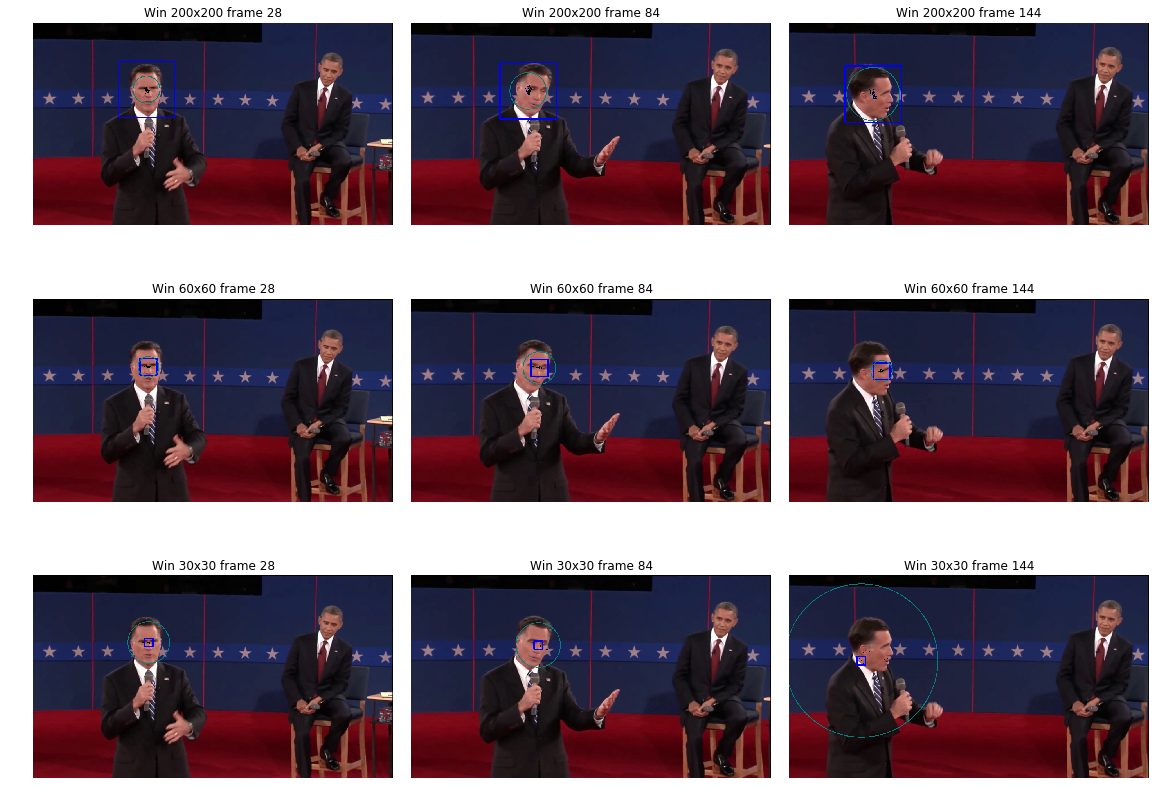

In [7]:
win200_28 = cv2.imread('output/Window_Influence/pres_debate_frame_28_w200.png')
win200_84 = cv2.imread('output/Window_Influence/pres_debate_frame_84_w200.png')
win200_144 = cv2.imread('output/Window_Influence/pres_debate_frame_144_w200.png')

win60_28 = cv2.imread('output/Window_Influence/pres_debate_frame_28_w60.png')
win60_84 = cv2.imread('output/Window_Influence/pres_debate_frame_84_w60.png')
win60_144 = cv2.imread('output/Window_Influence/pres_debate_frame_144_w60.png')

win30_28 = cv2.imread('output/Window_Influence/pres_debate_frame_28_w30.png')
win30_84 = cv2.imread('output/Window_Influence/pres_debate_frame_84_w30.png')
win30_144 = cv2.imread('output/Window_Influence/pres_debate_frame_144_w30.png')

plt.figure(figsize=(20,15))

plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.subplot(331)
plt.imshow(cv2.cvtColor(win200_28, cv2.COLOR_BGR2RGB))
plt.title('Win 200x200 frame 28')
plt.axis("off")
plt.subplot(332)
plt.imshow(cv2.cvtColor(win200_84, cv2.COLOR_BGR2RGB))
plt.title('Win 200x200 frame 84')
plt.axis("off")
plt.subplot(333)
plt.imshow(cv2.cvtColor(win200_144, cv2.COLOR_BGR2RGB))
plt.title('Win 200x200 frame 144')
plt.axis("off")

plt.subplot(334)
plt.imshow(cv2.cvtColor(win60_28, cv2.COLOR_BGR2RGB))
plt.title('Win 60x60 frame 28')
plt.axis("off")
plt.subplot(335)
plt.imshow(cv2.cvtColor(win60_84, cv2.COLOR_BGR2RGB))
plt.title('Win 60x60 frame 84')
plt.axis("off")
plt.subplot(336)
plt.imshow(cv2.cvtColor(win60_144, cv2.COLOR_BGR2RGB))
plt.title('Win 60x60 frame 144')
plt.axis("off")


plt.subplot(337)
plt.imshow(cv2.cvtColor(win30_28, cv2.COLOR_BGR2RGB))
plt.title('Win 30x30 frame 28')
plt.axis("off")
plt.subplot(338)
plt.imshow(cv2.cvtColor(win30_84, cv2.COLOR_BGR2RGB))
plt.title('Win 30x30 frame 84')
plt.axis("off")
plt.subplot(339)
plt.imshow(cv2.cvtColor(win30_144, cv2.COLOR_BGR2RGB))
plt.title('Win 30x30 frame 144')
plt.axis("off")

A bigger window will make the system more stable but will also require more computation because the patch will be bigger. <br>
As we can see in the results, with smaller windows we can still have a tracker which does the work, it will we lighter but in the simulations we can see that the tracking tends to shake, because there might multiple small patch on the skin of the face which are similar.<br>
Also with the window 30x30, we can see in frame 144 that when Romney moves his on the side, the standard deviation of the distribution explodes.

### 1.3 - Influence of the parameter $\sigma_{MSE}$

Here we will observe the influence of $\sigma_{MSE}$, used for the similarity measure between the patch of which a particle is the center and the patch we are tracking. <br>
Remember the expression we are usinf for the similarity function:
$$exp (-\frac{MSE}{2\sigma^2_{MSE}})$$

With MSE the squared difference between the two patches. <br>
Thus with a small $\sigma_{MSE}$, because the MSE value will be a big value, even a patch which is similar to the tracked patch will have a similarity close to a patch totally different form the tracked one. <br>
The results above were obtained with a $\sigma_{MSE}$ of 10. <br>
Also, a $\sigma_{MSE}$ too big will result in small similarity results between a patch close to the tracked patch and a one totally wrong. <br>
<br>
therefore, the value of $\sigma_{MSE}$ must be well chosen because if it's too high or too low, all the particles will end up with the same probability of being chosen, there would be no difference between a correct and an incorrect particle.

In [9]:
sig3_28 = cv2.imread('output/SigmaMSE/pres_debate_frame_28_sig3.png')
sig3_84 = cv2.imread('output/SigmaMSE/pres_debate_frame_84_sig3.png')
sig3_144 = cv2.imread('output/SigmaMSE/pres_debate_frame_144_sig3.png')

sig50_28 = cv2.imread('output/SigmaMSE/pres_debate_frame_28_sig50.png')
sig50_84 = cv2.imread('output/SigmaMSE/pres_debate_frame_84_sig50.png')
sig50_144 = cv2.imread('output/SigmaMSE/pres_debate_frame_144_sig50.png')

(-0.5, 1279.5, 719.5, -0.5)

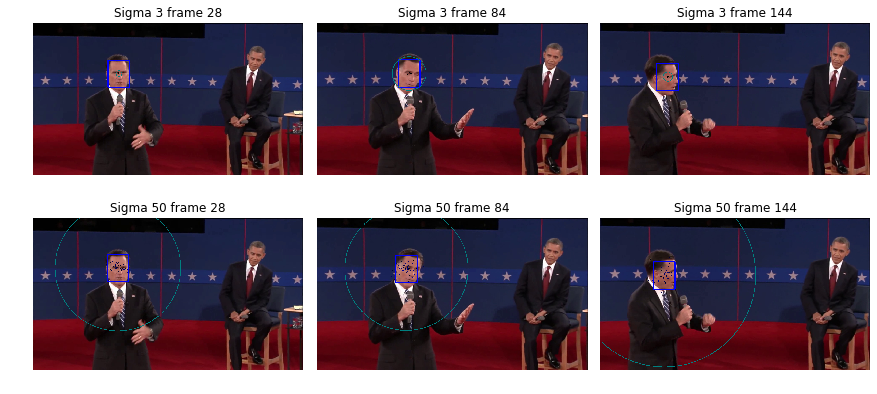

In [10]:
plt.figure(figsize=(15,7))

plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.subplot(231)
plt.imshow(cv2.cvtColor(sig3_28, cv2.COLOR_BGR2RGB))
plt.title('Sigma 3 frame 28')
plt.axis("off")
plt.subplot(232)
plt.imshow(cv2.cvtColor(sig3_84, cv2.COLOR_BGR2RGB))
plt.title('Sigma 3 frame 84')
plt.axis("off")
plt.subplot(233)
plt.imshow(cv2.cvtColor(sig3_144, cv2.COLOR_BGR2RGB))
plt.title('Sigma 3 frame 144')
plt.axis("off")

plt.subplot(234)
plt.imshow(cv2.cvtColor(sig50_28, cv2.COLOR_BGR2RGB))
plt.title('Sigma 50 frame 28')
plt.axis("off")
plt.subplot(235)
plt.imshow(cv2.cvtColor(sig50_84, cv2.COLOR_BGR2RGB))
plt.title('Sigma 50 frame 84')
plt.axis("off")
plt.subplot(236)
plt.imshow(cv2.cvtColor(sig50_144, cv2.COLOR_BGR2RGB))
plt.title('Sigma 50 frame 144')
plt.axis("off")

### 1.4 - Optimization of the particle number

Here we will study the effect of the number of particles on the tracking. Each particle represents a possible center of the patch we are tracking in the video. Thus the more particle we are considering and the more possible positions of the face in the frame we can consider. We have less chance of losing the face with more particles. <br>
Of course increasing the number of particles increases the amount of computation needed. 

In [12]:
part10_28 = cv2.imread('output/ParticleNumber/pres_debate_frame_28_part10.png')
part10_84 = cv2.imread('output/ParticleNumber/pres_debate_frame_84_part10.png')
part10_144 = cv2.imread('output/ParticleNumber/pres_debate_frame_144_part10.png')

part1000_28 = cv2.imread('output/ParticleNumber/pres_debate_frame_28_part1000.png')
part1000_84 = cv2.imread('output/ParticleNumber/pres_debate_frame_84_part1000.png')
part1000_144 = cv2.imread('output/ParticleNumber/pres_debate_frame_144_part1000.png')

(-0.5, 1279.5, 719.5, -0.5)

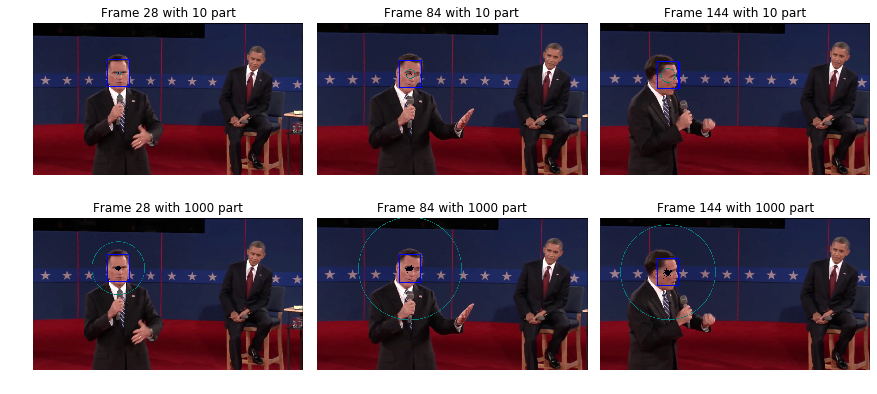

In [13]:
plt.figure(figsize=(15,7))

plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.subplot(231)
plt.imshow(cv2.cvtColor(part10_28, cv2.COLOR_BGR2RGB))
plt.title('Frame 28 with 10 part')
plt.axis("off")
plt.subplot(232)
plt.imshow(cv2.cvtColor(part10_84, cv2.COLOR_BGR2RGB))
plt.title('Frame 84 with 10 part')
plt.axis("off")
plt.subplot(233)
plt.imshow(cv2.cvtColor(part10_144, cv2.COLOR_BGR2RGB))
plt.title('Frame 144 with 10 part')
plt.axis("off")

plt.subplot(234)
plt.imshow(cv2.cvtColor(part1000_28, cv2.COLOR_BGR2RGB))
plt.title('Frame 28 with 1000 part')
plt.axis("off")
plt.subplot(235)
plt.imshow(cv2.cvtColor(part1000_84, cv2.COLOR_BGR2RGB))
plt.title('Frame 84 with 1000 part')
plt.axis("off")
plt.subplot(236)
plt.imshow(cv2.cvtColor(part1000_144, cv2.COLOR_BGR2RGB))
plt.title('Frame 144 with 1000 part')
plt.axis("off")

We cannot see here with only the frames, but with 1000 particles the tracking is really stable, but also quite slow compared to the tracking window with 10 particles, which tracking window tends to shake. <br>
Therefore here there is also a compromise to make in the choice of the number of particles we are considering. We want a stable system but also not slow, especially if we are doing real time tracking.

### 1.5 - Tracker on the noisy debate

Here we want to apply our tracking system to the same video but with added noise.

(-0.5, 1279.5, 719.5, -0.5)

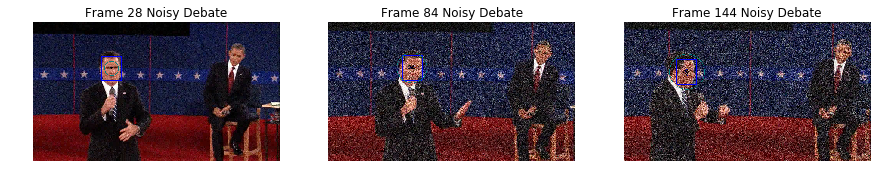

In [14]:
noisy_28 = cv2.imread('output/NoisyDebate/pres_debate_frame_28_noisy.png')
noisy_84 = cv2.imread('output/NoisyDebate/pres_debate_frame_84_noisy.png')
noisy_144 = cv2.imread('output/NoisyDebate/pres_debate_frame_144_noisy.png')

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(cv2.cvtColor(noisy_28, cv2.COLOR_BGR2RGB))
plt.title('Frame 28 Noisy Debate')
plt.axis("off")
plt.subplot(132)
plt.imshow(cv2.cvtColor(noisy_84, cv2.COLOR_BGR2RGB))
plt.title('Frame 84 Noisy Debate')
plt.axis("off")
plt.subplot(133)
plt.imshow(cv2.cvtColor(noisy_144, cv2.COLOR_BGR2RGB))
plt.title('Frame 144 Noisy Debate')
plt.axis("off")

As we can see our system is stable against noise.

# 2 - Appearance Model Update

In this part we will attempt to track the left hand of Romney, which moves much more than his face and whose movement is not just a translation. <br> 
To do that we will modify our class by making it less naive. Instead of tracking always the same patch we will track a patch which is a combination between the original patch and the previous patch selected which the patch whose center is the weighted mean of the state of all the particles.

In [11]:
def measure_hand(particle_patch ,tracked_patch, std_MSE=5):
    cv2.normalize(particle_patch, particle_patch, alpha=0, beta=255,
                               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.normalize(tracked_patch, tracked_patch, alpha=0, beta=255,
                               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    dissimilarity = np.subtract(particle_patch, tracked_patch, dtype=np.float32) ** 2
    #cv2.normalize(dissimilarity, dissimilarity, alpha=0, beta=255,
    #                           norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    mse =np.mean(dissimilarity)
    return np.exp(-mse / 2 / float(std_MSE)**2)

In [12]:
class LessNaiveParticleFilter:
    def __init__(self, state, tracked_patch, previous_state, window_size, part_nb, alpha, std_pred=10, std_up=5):
        self.std_pred = std_pred
        self.std_up = std_up
        self.tracked_patch = tracked_patch
        self.state = state
        self.weights = np.ones(np.shape(state)[0])/np.shape(state)[0]
        self.window_size = window_size
        self.part_nb = part_nb
        self.alpha = alpha
        self.previous_state = previous_state
        
    def predict(self):
        self.previous_state = self.state
        noise = np.random.randn(self.part_nb, 2) * self.std_pred
        #noise=np.random.normal(0.0, self.std_pred, (self.part_nb, 2))
        self.state+=noise

    def get_weights(self, frame):
        err_part = np.zeros(self.part_nb) 
        
        pr_st_x = np.average(self.previous_state[:,0], weights = self.weights)
        pr_st_y = np.average(self.previous_state[:,1], weights = self.weights)
        
        previous_patch = get_patch([pr_st_x,pr_st_y], frame, self.window_size)
        #self.tracked_patch = (self.alpha*previous_patch).astype(float) + (float(1.0-self.alpha)*self.tracked_patch).astype(float)
        self.tracked_patch = self.alpha*previous_patch + (1-self.alpha)*cv2.resize(self.tracked_patch.copy(), (self.window_size)).astype(np.float32)
        
        for ind, part in enumerate(self.state):        
            part_patch = get_patch(part, frame, self.window_size) 
            err_part[ind] = measure_hand(part_patch,self.tracked_patch)
        self.weights = err_part/np.sum(err_part)

    def update(self, frame):
        self.get_weights(frame)
        indsampled = np.random.choice(self.part_nb, size=self.part_nb, replace=True, p=self.weights)
        up_state = self.state[indsampled]
        #print("up_state",up_state)
        
        self.state = up_state #+ np.random.normal(0.0, self.std_up, (self.part_nb, 2))
        
    def draw_particles(self,frame):
        #for ind, part in enumerate(self.state):
         #   cv2.circle(frame,(part[0].astype(int),part[1].astype(int)),2,(0,0,255), -1)
        weights_for_color = ((self.weights - self.weights.min()) / self.weights.max() * 255).astype(int)
        for p, w in zip(self.state, weights_for_color.tolist()):
            cv2.circle(frame, (int(p[0]), int(p[1])), 2, (w,0,0), -1)            
            

    def draw_tracking_window(self,frame):
        w,h = self.window_size
        
        est_x = np.average(self.state[:,0], weights = self.weights)
        est_y = np.average(self.state[:,1], weights = self.weights)
        
        top_u_curr=int(est_x - w/2)
        top_v_curr=int(est_y - h/2)
        cv2.rectangle(frame,(top_u_curr,top_v_curr),(int(top_u_curr+w),int(top_v_curr+h)),(255, 255, 0), 3)
        
    def draw_std_circle(self,frame):
        est_x = np.average(self.state[:,0], weights = self.weights)
        est_y = np.average(self.state[:,1], weights = self.weights)
        
        average_state = np.zeros((self.part_nb,2))
        average_state[:,0] = est_x
        average_state[:,1] = est_y
        
        distance = np.linalg.norm(self.state - average_state)
        radius = np.sum(distance * self.weights)
        
        cv2.circle(frame,(int(est_x),int(est_y)),int(radius),(128,128,0), 2)
        
        

In [13]:
part_nb_hand = 100
#alpha = 0.2

corn_u_hand, corn_v_hand ,w_hand ,h_hand = 523, 380, 90, 125
window_size_hand=(w_hand,h_hand)

initial_state_hand=np.zeros((part_nb_hand,2))
initial_state_hand[:,0],initial_state_hand[:,1]=(corn_u_hand+w/2).astype(int),(corn_v_hand+h/2).astype(int)
tracked_patch_hand = get_patch([int(corn_u_hand+w/2),int(corn_v_hand+h/2)],first_frame,window_size_hand)

pf_n_naive = LessNaiveParticleFilter(initial_state_hand, tracked_patch_hand, initial_state_hand, window_size_hand, part_nb=part_nb_hand, alpha = 0.1)

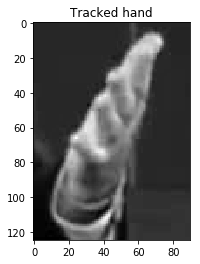

In [14]:
plt.title("Tracked hand")
plt.imshow(tracked_patch_hand, cmap='gray')

In [21]:
part_nb_hand = 200
#alpha = 0.2

corn_u_hand, corn_v_hand ,w_hand ,h_hand = 523, 380, 90, 125
window_size_hand=(w_hand,h_hand)

initial_state_hand=np.zeros((part_nb_hand,2))
#initial_state_hand[:,0],initial_state_hand[:,1]=(corn_u_hand+w/2).astype(int),(corn_v_hand+h/2).astype(int)
initial_state_hand[:,0],initial_state_hand[:,1]=578,452
tracked_patch_hand = get_patch([int(corn_u_hand+w/2),int(corn_v_hand+h/2)],first_frame,window_size_hand)

pf_n_naive = LessNaiveParticleFilter(initial_state_hand, tracked_patch_hand, initial_state_hand, window_size_hand, part_nb=part_nb_hand, alpha = 0.1)


#video = cv2.VideoCapture('pres_debate.avi')   
video = cv2.VideoCapture('noisy_debate.avi')

frames_counter = 0

while video.isOpened():
    frames_counter = frames_counter + 1
    check, frame = video.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    pf_n_naive.predict()
    pf_n_naive.get_weights(gray)
    pf_n_naive.update(gray)
    
    pf_n_naive.draw_particles(frame)
    pf_n_naive.draw_tracking_window(frame)
    pf_n_naive.draw_std_circle(frame)
    
    if not check:
        break
    
    if frames_counter == 28:
        cv2.imwrite('output/HandTracking/pres_debate_frame_28_hand_noisy.png', frame)
    
    if frames_counter == 84:
        cv2.imwrite('output/HandTracking/pres_debate_frame_84_hand_noisy.png', frame)
    
    if frames_counter == 144:
        cv2.imwrite('output/HandTracking/pres_debate_frame_144_hand_noisy.png', frame)
        
    

    
    cv2.imshow("Capturing", frame)
    #cv2.waitKey(0)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
    
print("Number of frames in the video: ", frames_counter)
video.release()
cv2.destroyAllWindows()

Number of frames in the video:  179


(-0.5, 1279.5, 719.5, -0.5)

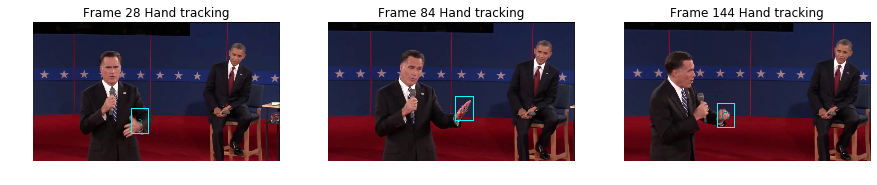

In [85]:
hand_28 = cv2.imread('output/HandTracking/pres_debate_frame_28_hand.png')
hand_84 = cv2.imread('output/HandTracking/pres_debate_frame_84_hand.png')
hand_144 = cv2.imread('output/HandTracking/pres_debate_frame_144_hand.png')

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(cv2.cvtColor(hand_28, cv2.COLOR_BGR2RGB))
plt.title('Frame 28 Hand tracking')
plt.axis("off")
plt.subplot(132)
plt.imshow(cv2.cvtColor(hand_84, cv2.COLOR_BGR2RGB))
plt.title('Frame 84 Hand tracking')
plt.axis("off")
plt.subplot(133)
plt.imshow(cv2.cvtColor(hand_144, cv2.COLOR_BGR2RGB))
plt.title('Frame 144 Hand tracking')
plt.axis("off")

Here are the results for my hand tracking. As you can see my detector works but in some frames it has some difficulties to precisely track the hand.

## Hand tracking on noisy debate

(-0.5, 1279.5, 719.5, -0.5)

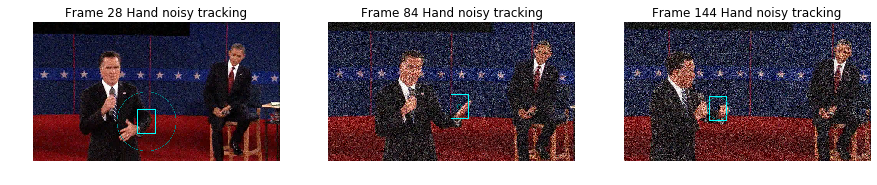

In [22]:
hand_noisy_28 = cv2.imread('output/HandTracking/pres_debate_frame_28_hand_noisy.png')
hand_noisy_84 = cv2.imread('output/HandTracking/pres_debate_frame_84_hand_noisy.png')
hand_noisy_144 = cv2.imread('output/HandTracking/pres_debate_frame_144_hand_noisy.png')

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(cv2.cvtColor(hand_noisy_28, cv2.COLOR_BGR2RGB))
plt.title('Frame 28 Hand noisy tracking')
plt.axis("off")
plt.subplot(132)
plt.imshow(cv2.cvtColor(hand_noisy_84, cv2.COLOR_BGR2RGB))
plt.title('Frame 84 Hand noisy tracking')
plt.axis("off")
plt.subplot(133)
plt.imshow(cv2.cvtColor(hand_noisy_144, cv2.COLOR_BGR2RGB))
plt.title('Frame 144 Hand noisy tracking')
plt.axis("off")

In the debate video with noise, our system shows some difficulties to track the hand, it can follow the hand, but not really precisely.